# LSTMs for Human Activity Recognition

Human activity recognition using smartwatch dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. Other research on the activity recognition dataset used mostly use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much did the data was preprocessed. 

## Details about input data

I will be using an LSTM on the data to learn (as a smartwatch attached on the wrist) to recognise the type of activity that the user is doing. A similar dataset's description based on prior research goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data. 

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of feature vectors (one vector per time step) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" />

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. 


## Results 

Scroll on! Nice visuals awaits. 

In [25]:
# All Includes

import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [5]:
import glob
import h5py
%matplotlib inline

mat_names = glob.glob('../project_datasets/*.mat')
# each test subject got a different file - 9 test subjects
print(mat_names)

matfile = h5py.File(mat_names[0], 'r')
print(matfile.keys()) #image and type

image_mat = matfile['image']
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

['../project_datasets/A07T_slice.mat', '../project_datasets/A08T_slice.mat', '../project_datasets/A09T_slice.mat', '../project_datasets/A03T_slice.mat', '../project_datasets/A04T_slice.mat', '../project_datasets/A01T_slice.mat', '../project_datasets/A05T_slice.mat', '../project_datasets/A06T_slice.mat', '../project_datasets/A02T_slice.mat']
[u'image', u'type']
(288, 25, 1000)


In [6]:
type_mat = matfile['type']
type_shape = type_mat.shape
print type_shape
# plt.plot(type_mat[0,:288]) # gets the significant values of types
# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

nans = np.sum(np.isnan(image_mat[:,:]))
print(nans) #No NaN in the data
print len(image_mat[0:,:])
count = 0
# for i in range(len(image_mat[0:,:])):
#  if np.sum(np.isnan(image_mat[i:,:])):
#         pass

type_set = list(set(type_mat[0,:]))
print(type_set) 

(1, 1000)
0
288
[0.0, 769.0, 770.0, 771.0, 772.0]


In [7]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [63]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [64]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [65]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [66]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

new_axis = (0,2,1)
rnn_trainval_data_X = np.transpose(rnn_trainval_data_X, new_axis)
rnn_training_data_X = np.transpose(rnn_training_data_X, new_axis)
rnn_validation_data_X = np.transpose(rnn_validation_data_X, new_axis)
rnn_test_data_X = np.transpose(rnn_test_data_X, new_axis)

# repeating the Y labels for the rnn
N_trainval, T, E = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [67]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [68]:
mean_list = np.mean(rnn_trainval_data_X.reshape(-1, rnn_trainval_data_X.shape[-1]), axis=0)
std_list = np.sqrt((np.var(rnn_trainval_data_X.reshape(-1, rnn_trainval_data_X.shape[-1]), axis=0)))
print(mean_list)
print(std_list)

[0.24211577 0.29200906 0.28058568 0.28058862 0.27744969 0.30503537
 0.37432564 0.35469766 0.29599771 0.28391495 0.28070525 0.32476685
 0.33706837 0.3755972  0.37135214 0.37447009 0.3089289  0.33019716
 0.29176846 0.34339516 0.36118418 0.32799225]
[11.27145177 10.2505745  10.92481975 11.49970902 11.21479773 10.89149331
  8.71352886 10.06750202 10.70168511 11.33973592 10.97697775 10.88472781
 10.10025118 10.33649046 10.64618123 11.09796571 10.98326707 11.08252466
 10.81161869 11.24811363 11.16262363 11.35832584]


In [69]:
rnn_trainval_data_X = (rnn_trainval_data_X - mean_list)/std_list
rnn_training_data_X = (rnn_training_data_X - mean_list)/std_list
rnn_validation_data_X = (rnn_validation_data_X - mean_list)/std_list
rnn_test_data_X = (rnn_test_data_X - mean_list)/std_list

In [70]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 1000, 22)
(2115,)


In [71]:
set(rnn_trainval_data_Y)

{0.0, 1.0, 2.0, 3.0}

In [72]:
# Useful Constants

# Those are separate normalised input features for the neural network

# Output classes to learn how to classify
LABELS = [
    "LEFT",
    "RIGHT",
    "FOOT",
    "TONGUE"
    
] 


In [76]:
pandas.DataFrame(rnn_trainval_data_X[3]).describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.019228,-0.082219,-0.075826,-0.047379,-0.050532,-0.060178,-0.063592,-0.079086,-0.051713,-0.044552,...,-0.049065,-0.060679,-0.061354,-0.056502,-0.046323,-0.063935,-0.059752,-0.086984,-0.081453,-0.055814
std,0.656299,0.594934,0.653857,0.670126,0.748175,0.684128,0.582003,0.595916,0.659181,0.691749,...,0.662745,0.646819,0.665252,0.665526,0.664200,0.651515,0.680298,0.660292,0.651054,0.725231
min,-1.658983,-1.633771,-1.791123,-1.926622,-1.992703,-2.157500,-2.228408,-1.994662,-1.975914,-1.803387,...,-2.368362,-2.147902,-2.208856,-1.837634,-2.104261,-2.179857,-2.172212,-2.166304,-2.175740,-2.100939
25%,-0.472010,-0.485779,-0.526264,-0.492525,-0.566800,-0.494254,-0.452030,-0.482651,-0.497613,-0.529908,...,-0.502304,-0.489827,-0.490086,-0.482515,-0.481587,-0.480294,-0.501194,-0.508040,-0.500401,-0.544743
50%,-0.066967,-0.128520,-0.132951,-0.088090,-0.113995,-0.106462,-0.087789,-0.107983,-0.082411,-0.076708,...,-0.069630,-0.090661,-0.096798,-0.068940,-0.061470,-0.093679,-0.106021,-0.113008,-0.106719,-0.101958
75%,0.390061,0.277565,0.307292,0.340759,0.368200,0.339611,0.310075,0.304273,0.347620,0.389409,...,0.359418,0.347477,0.336621,0.327036,0.345310,0.341400,0.329798,0.286364,0.286964,0.393489
max,3.006600,2.648573,2.950982,3.338457,3.754447,3.074328,1.839889,2.084250,2.691685,3.032174,...,2.644856,2.377555,2.643603,3.024075,2.692631,2.459520,2.529219,2.539346,2.535329,2.675121


## Additionnal Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [77]:
# Input Data 
X_train = rnn_training_data_X
X_test = rnn_test_data_X
X_val = rnn_validation_data_X
y_train = rnn_training_data_Y
y_test = rnn_test_data_Y
y_val = rnn_validation_data_Y

training_data_count = len(X_train)  # 2115 training series 
test_data_count = len(X_test)  # 443 testing series
n_steps = len(X_train[0])  # 1000 timesteps per series
n_input = len(X_train[0][0])  # 22 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 4 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
dropout = 1.0
lambda_loss_amount = 0.0015
training_iters = training_data_count * 100  # Loop 10 times on the dataset
batch_size = 100
display_iter = 10000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
((443, 1000, 22), (443,), 0.0016580587469994378, 0.997292271181712)
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


## Utility functions for training:

In [78]:
def LSTM_RNN(_X, _weights, _biases, _keep_prob):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']
    # Dropout
    _X = tf.nn.dropout(_X, _keep_prob)
    #RELU
    _X = tf.nn.relu(_X)
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


In [23]:
one_hot(np.asarray([[3], [0], [3]]))

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

## Let's get serious and build the neural network:

In [79]:
tf.reset_default_graph()
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases, keep_prob)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Hooray, now train the neural network:

In [80]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
test_cross_losses = []
test_cross_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
saver = tf.train.Saver()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)
saver.save(sess, './Checkpoints/mytestmodel.ckpt')

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys,
            keep_prob : dropout
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        saver.save(sess, './Checkpoints/mytestmodel.ckpt', global_step=step,write_meta_graph=False)
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_val,
                y: one_hot(y_val),
                keep_prob : 1.0
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON VALIDATION SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the cross test set (no learning made here - just evaluation for diagnosis)
        loss_c, acc_c = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test),
                keep_prob : 1.0
            }
        )
        test_cross_losses.append(loss_c)
        test_cross_accuracies.append(acc_c)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss_c) + \
              ", Accuracy = {}".format(acc_c))

    step += 1

print("Optimization Finished!")
saver.save(sess, './Checkpoints/final/finalmodel.ckpt')

Training iter #100:   Batch Loss = 2.977999, Accuracy = 0.239999994636
PERFORMANCE ON VALIDATION SET: Batch Loss = 2.74006271362, Accuracy = 0.229411765933
PERFORMANCE ON TEST SET: Batch Loss = 2.62529730797, Accuracy = 0.250564336777
Training iter #10000:   Batch Loss = 2.105486, Accuracy = 0.330000013113
PERFORMANCE ON VALIDATION SET: Batch Loss = 2.14856958389, Accuracy = 0.241176471114
PERFORMANCE ON TEST SET: Batch Loss = 2.16382074356, Accuracy = 0.261851012707
Training iter #20000:   Batch Loss = 1.889123, Accuracy = 0.409999996424
PERFORMANCE ON VALIDATION SET: Batch Loss = 2.08928704262, Accuracy = 0.264705896378
PERFORMANCE ON TEST SET: Batch Loss = 2.12541246414, Accuracy = 0.232505649328
Training iter #30000:   Batch Loss = 1.705281, Accuracy = 0.5
PERFORMANCE ON VALIDATION SET: Batch Loss = 2.13747191429, Accuracy = 0.244117647409
PERFORMANCE ON TEST SET: Batch Loss = 2.09840655327, Accuracy = 0.286681711674
Training iter #40000:   Batch Loss = 1.559277, Accuracy = 0.54000

'./Checkpoints/final/finalmodel.ckpt'

In [81]:
# Accuracy for test data
sess = tf.Session()
saver.restore(sess, "./Checkpoints/final/finalmodel.ckpt")
one_hot_predictions, acc, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_val,
        y: one_hot(y_val),
        keep_prob : 1.0
    }
)

test_losses.append(final_loss)
test_accuracies.append(acc)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(acc))

INFO:tensorflow:Restoring parameters from ./Checkpoints/final/finalmodel.ckpt
FINAL RESULT: Batch Loss = 4.73697471619, Accuracy = 0.244117647409


In [83]:
# Accuracy for cross test data
one_hot_predictions_c, accuracy_c, final_loss_c = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test),
        keep_prob : 1.0
    }
)

print("FINAL RESULT Cross Data: " + \
      "Batch Loss = {}".format(final_loss_c) + \
      ", Accuracy = {}".format(accuracy_c))

FINAL RESULT Cross Data: Batch Loss = 4.64937353134, Accuracy = 0.250564336777


## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

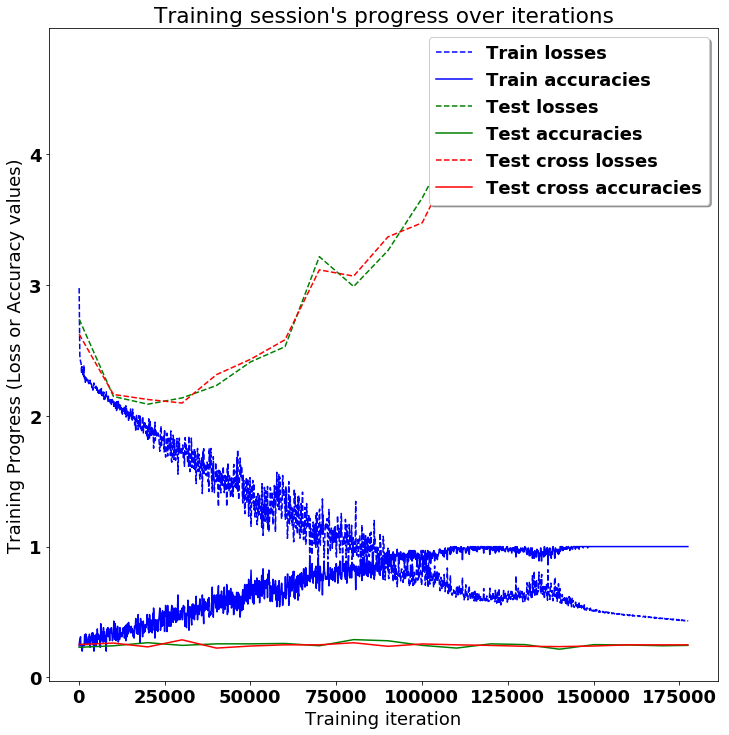

In [84]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "b-", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "g--", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

indep_test_c_axis = np.append(
   np.array(range(batch_size, len(test_cross_losses)*display_iter, display_iter)[:-1]),
   [training_iters]
)
plt.plot(indep_test_c_axis, np.array(test_cross_losses),     "r--", label="Test cross losses")
plt.plot(indep_test_c_axis, np.array(test_cross_accuracies), "r-", label="Test cross accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

Testing Accuracy: Tensor("mul_2:0", shape=(), dtype=float32)%

Precision: 25.2777529142%
Recall: 25.0564334086%
f1_score: 24.9054551916%

Confusion Matrix:
[[25 30 36 19]
 [40 25 26 30]
 [20 17 31 22]
 [28 32 32 30]]

Confusion matrix (normalised to % of total test data):
[[5.643341  6.7720094 8.1264105 4.288939 ]
 [9.0293455 5.643341  5.8690743 6.7720094]
 [4.5146728 3.8374717 6.9977427 4.96614  ]
 [6.3205423 7.2234764 7.2234764 6.7720094]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 4th of the data is correctly classifier in the last category.


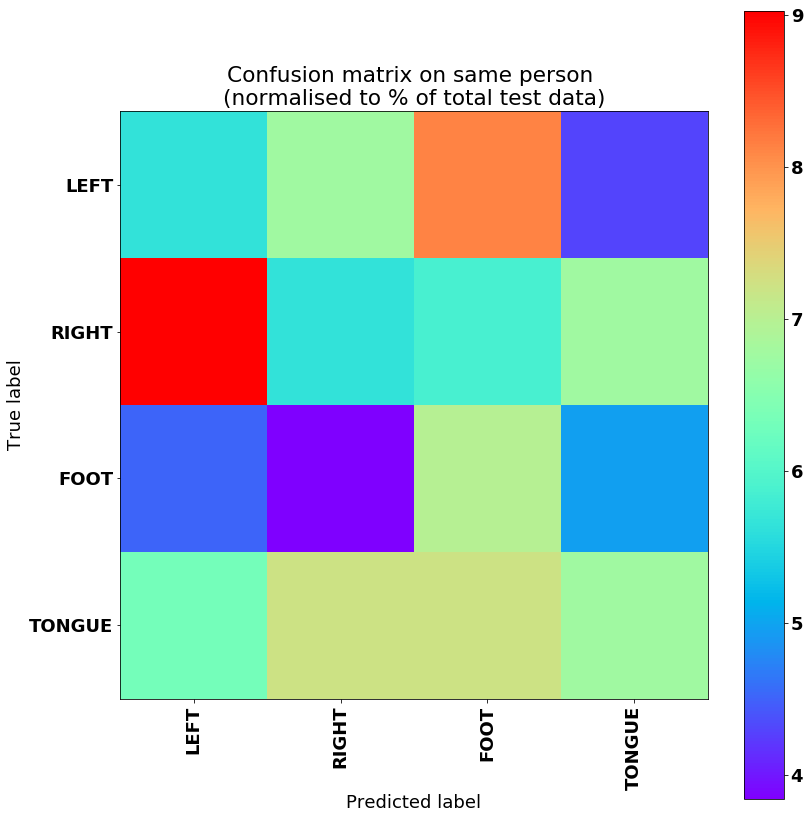

In [86]:
# Results

predictions = one_hot_predictions_c.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 4th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix on same person \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Testing Accuracy: Tensor("mul_4:0", shape=(), dtype=float32)%

Precision: 24.5264466546%
Recall: 24.4117647059%
f1_score: 24.3234151633%

Confusion Matrix:
[[19 16 31 21]
 [21 18 30 19]
 [20 19 24 22]
 [12 26 20 22]]

Confusion matrix (normalised to % of total test data):
[[5.5882354 4.7058825 9.117647  6.1764708]
 [6.1764708 5.294118  8.823529  5.5882354]
 [5.882353  5.5882354 7.058824  6.4705887]
 [3.529412  7.647059  5.882353  6.4705887]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 4th of the data is correctly classifier in the last category.


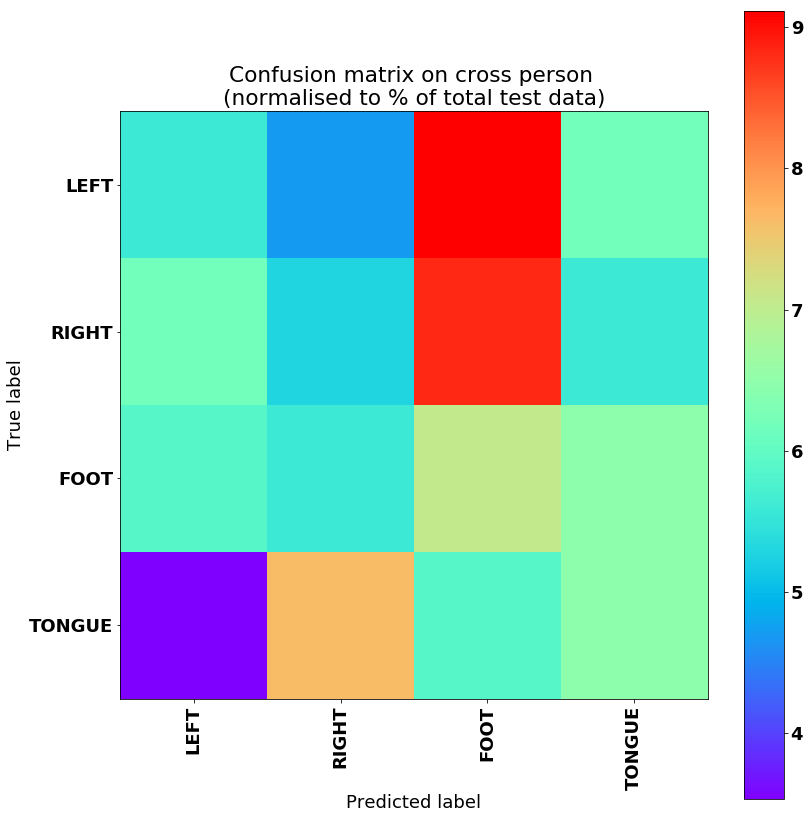

In [88]:
# Results

predictions = one_hot_predictions.argmax(1)
Y_c = y_val
print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(Y_c, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Y_c, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Y_c, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Y_c, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 4th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix on cross person \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
sess.close()

## Conclusion

Outstandingly, **the final accuracy is of 93.6%**! And it can peak to values such as 95.6%, at some moments of luck during the training, depending on how the neural network's weights got initialized at the start of the training, randomly. 

This means that the neural networks is almost always able to correctly identify the movement type!

I specially did not expect such good results for guessing between "WALKING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at wrist level according to how the dataset was gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away from the identity. This is great.

## References

The code is based on the following repository: 
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition


In [46]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Support files will be in LSTM_files/
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Making directory LSTM_files
[NbConvertApp] Writing 48861 bytes to LSTM.md
